# PRACTICA NLP ROBERTO MARTINEZ CAMACHO

# Ejercicio 2 - Analisis de sentimiento

Imports y librerias

In [1]:
import sys
import json
import pandas as pd
import numpy as np
from collections import Counter
import string
import os
import random
import re

import spacy

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer


from stop_words import get_stop_words

import gensim
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel

import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sys.path.append('../..')

# Lectura de datos

In [2]:
reviews_dict_baby = []
for line in open('../../Práctica Final/Baby_5.json', 'r'):
    reviews_dict_baby.append(json.loads(line))
    
print(len(reviews_dict_baby))

df_baby = pd.DataFrame(reviews_dict_baby)
df_baby[df_baby.columns.values[5]].value_counts()

160792


5.0    93526
4.0    32999
3.0    17255
2.0     9193
1.0     7819
Name: overall, dtype: int64

In [3]:
reviews_dict_phones = []
for line in open('../../Práctica Final/Cell_Phones_and_Accessories_5.json', 'r'):
    reviews_dict_phones.append(json.loads(line))
    
print(len(reviews_dict_phones))

df_phones = pd.DataFrame(reviews_dict_phones)
df_phones[df_phones.columns.values[5]].value_counts()

194439


5.0    108664
4.0     39993
3.0     21439
1.0     13279
2.0     11064
Name: overall, dtype: int64

In [4]:
reviews_dict_music = []
for line in open('../../Práctica Final/Digital_Music_5.json', 'r'):
    reviews_dict_music.append(json.loads(line))
    
print(len(reviews_dict_music))

df_music = pd.DataFrame(reviews_dict_music)
df_music[df_music.columns.values[5]].value_counts()

64706


5.0    35580
4.0    16536
3.0     6789
2.0     3010
1.0     2791
Name: overall, dtype: int64

In [5]:
reviews_dict_toys = []
for line in open('../../Práctica Final/Toys_and_Games_5.json', 'r'):
    reviews_dict_toys.append(json.loads(line))
    
print(len(reviews_dict_toys))

df_toys = pd.DataFrame(reviews_dict_toys)
df_toys[df_toys.columns.values[5]].value_counts()

167597


5.0    102790
4.0     37445
3.0     16357
2.0      6298
1.0      4707
Name: overall, dtype: int64

In [6]:
reviews_dict_games = []
for line in open('../../Práctica Final/Video_Games_5.json', 'r'):
    reviews_dict_games.append(json.loads(line))
    
print(len(reviews_dict_games))

df_games = pd.DataFrame(reviews_dict_games)
df_games[df_games.columns.values[5]].value_counts()

231780


5.0    120185
4.0     54804
3.0     28275
1.0     14853
2.0     13663
Name: overall, dtype: int64

Hemos cargado los 5 datasets que vamos a utilizar (reviews de bebes, musica, telefonos, juguetes y videojuegos) y comprobamos que todos cuentan con las mismas columnas, vamos a realizar un drop() de aquellas que no aportan informacion para el analisis de sentimiento.

In [7]:
#df_baby
#df_music
#df_phones
#df_toys
#df_games

In [8]:
df_baby.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [9]:
cols_to_drop = ['reviewerID', 'asin', 'reviewerName', 'helpful', 'summary', 'unixReviewTime', 'reviewTime']

In [10]:
df_baby = df_baby.drop(cols_to_drop, axis=1)
df_music = df_music.drop(cols_to_drop, axis=1)
df_phones = df_phones.drop(cols_to_drop, axis=1)
df_toys = df_toys.drop(cols_to_drop, axis=1)
df_games = df_games.drop(cols_to_drop, axis=1)

Seleccionamos un subconjunto de los registros para poder trabajar con ellos.

In [11]:
#df_baby_sub = df_baby[:10000]
#df_music_sub = df_music[:10000]
#df_phones_sub = df_phones[:10000]
#df_toys_sub = df_toys[:10000]
#df_games_sub = df_games[:10000]

In [12]:
#df_baby_sub = df_baby[:5000]
#df_music_sub = df_music[:5000]
#df_phones_sub = df_phones[:5000]
#df_toys_sub = df_toys[:5000]
#df_games_sub = df_games[:5000]

In [13]:
#df_games_sub.describe()

In [14]:
#df_baby_sub['origin'] = 'baby'
#df_music_sub['origin'] = 'music'
#df_phones_sub['origin'] = 'phones'
#df_toys_sub['origin'] = 'toys'
#df_games_sub['origin'] = 'games'

In [15]:
df = pd.concat([df_baby, df_music, df_phones, df_toys, df_games], join='inner', ignore_index = True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df

(819314, 2)


,reviewText,overall
0,I thought this thing would just sit around in ...,5.0
1,The cable only works when plugged in one direc...,3.0
2,My for years old boy absolutely ooves this toy...,5.0
3,Its a good case for my Note 2. I think it may...,3.0
4,Pele is a hawaiian God where they offer boys a...,5.0
...,...,...
819309,This toy is so cute and sturdy. He bangs it ar...,5.0
819310,Love this simple case. It's perfect for the p...,5.0
819311,My 3. y.o. loves his LeapPad tablet and he at ...,5.0
819312,Call of Duty: United Offensive Expansion Pack ...,5.0


En este ejercicio no nos interesa tanto de que producto provenga la valoracion (no vamos a analizar las reviews concretas de un producto) nos interesa viendo el desbalanceo de las valoraciones, juntar todos los datasets independientemente de si tenemos mas pos o neg de uno u otro producto.

Vemos en la celda siguiente que al juntar los datasets como veniamos observando, las puntuaciones negativas (1-2) son muy pocas, vamos a contar la puntuacion 3 como negativa tambien y balancear los datos pos-neg.

In [16]:
df[df.columns.values[1]].value_counts()

5.0    460745
4.0    181777
3.0     90115
1.0     43449
2.0     43228
Name: overall, dtype: int64

Aqui definimos una funcion que nos va a etiquetar como neg las valoraciones menor o igual que 3 y el resto como pos.

In [17]:
def label_sentiment(row):
    if int(row['overall']) <= 3:
        return 'neg'
    else:
        return 'pos'

In [18]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [19]:
print(df[df.columns.values[2]].value_counts())
df.head()

pos    642522
neg    176792
Name: sentiment_label, dtype: int64


,reviewText,overall,sentiment_label
0,I thought this thing would just sit around in ...,5.0,pos
1,The cable only works when plugged in one direc...,3.0,neg
2,My for years old boy absolutely ooves this toy...,5.0,pos
3,Its a good case for my Note 2. I think it may...,3.0,neg
4,Pele is a hawaiian God where they offer boys a...,5.0,pos


In [20]:
#nLabels = 1000
#nLabels = 5000
#nLabels = 10000
nLabels = 25000

In [21]:
# Separate majority and minority classes
df_majority = df[df.sentiment_label=='pos']
df_minority = df[df.sentiment_label=='neg']

In [22]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=nLabels,    # to match majority class
                                 random_state=123) # reproducible results

In [23]:
# Upsample majority class
df_majority_upsampled = resample(df_majority, 
                                 replace=True,     # sample with replacement
                                 n_samples=nLabels,    # to match majority class
                                 random_state=123) # reproducible results

In [24]:
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_upsampled, df_minority_upsampled])

In [68]:
# Display new class counts
df = df_upsampled
df = df.sample(frac=1).reset_index(drop=True)
print(df.sentiment_label.value_counts())
df.head()

pos    25000
neg    25000
Name: sentiment_label, dtype: int64


,reviewText,overall,sentiment_label,rating
0,we complaints product well made grandchildren ...,3.0,neg,"{'neg': 0.184, 'neu': 0.545, 'pos': 0.271, 'co..."
1,probably fault doesn t hold phone maybe one cr...,3.0,neg,"{'neg': 0.113, 'neu': 0.654, 'pos': 0.233, 'co..."
2,this item doesnt charge two devices timedoes c...,1.0,neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,it s cool idea but darn thing keeps closing ba...,1.0,neg,"{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp..."
4,this toy thrill son way baby einstein toy pian...,3.0,neg,"{'neg': 0.123, 'neu': 0.658, 'pos': 0.219, 'co..."


Lo que hemos realizado en las celdas de arriba es definir 2 funciones que nos cargan con X registros que indiquemos (nLabels) para que el dataset a la hora de concatenarlo este balancecado.

# Preprocesado

Vamos ha realizar primero un preprocesado muy sencillo para ver como etiqueta los textos como positivo o negativo.

Vamos a eliminar stopWords con el metodo get_stop_words('en')

In [69]:
stop_words = get_stop_words('en')

def remove_stopWords(s):
    '''For removing stop words
    '''
    s = ' '.join(word for word in s.split() if word not in stop_words)
    return s

df.loc[:,"reviewText"] = df.reviewText.apply(lambda x: remove_stopWords(x))

Como hemos indicado vamos a realizar un preprocesado muy sencillo, convertimos a minusculas para no tener palabras "duplicadas" Love-love

In [70]:
df.loc[:,"reviewText"] = df.reviewText.apply(lambda x : str.lower(x))

In [71]:
df.loc[:,"reviewText"] = df.reviewText.apply(lambda x : " ".join(re.findall('[\w]+',x)))

<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<>:1: DeprecationWarning: invalid escape sequence \w
<ipython-input-71-c35fc54fcb38>:1: DeprecationWarning: invalid escape sequence \w
  df.loc[:,"reviewText"] = df.reviewText.apply(lambda x : " ".join(re.findall('[\w]+',x)))


In [72]:
df.head()

,reviewText,overall,sentiment_label,rating
0,complaints product well made grandchildren lov...,3.0,neg,"{'neg': 0.184, 'neu': 0.545, 'pos': 0.271, 'co..."
1,probably fault doesn t hold phone maybe one cr...,3.0,neg,"{'neg': 0.113, 'neu': 0.654, 'pos': 0.233, 'co..."
2,item doesnt charge two devices timedoes charge...,1.0,neg,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,s cool idea darn thing keeps closing baby s mo...,1.0,neg,"{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp..."
4,toy thrill son way baby einstein toy piano dis...,3.0,neg,"{'neg': 0.123, 'neu': 0.658, 'pos': 0.219, 'co..."


# Separamos en conjunto de train y test

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    df['reviewText'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [74]:
X_train.iloc[:10]

27434    5 year old daughter 7 year old son love play g...
13400    charger takes day charge phone previous simila...
883      sounds quality great loud never issue connecti...
7303     fan monster high eight year old granddaughter ...
45124    two obvious limitations stand s quite evident ...
874      note rating purely based premium edt game s ac...
45943    expansion packs just keep getting better bette...
11458    learning resources great products 4 year loves...
23877    fyi amazon s game download service slow receiv...
11       son play much just entertaining thought maybe ...
Name: reviewText, dtype: object

In [75]:
y_train.iloc[:10]

27434    pos
13400    neg
883      pos
7303     pos
45124    pos
874      pos
45943    pos
11458    pos
23877    pos
11       pos
Name: sentiment_label, dtype: object

# Extraccion de features

In [76]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=1500,
    strip_accents='ascii',
    ngram_range=(1, 1) #variar el rango para el ngram
    #ngram_range=(2, 3)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=1500, min_df=5, strip_accents='ascii')

In [77]:
print(list(cv.vocabulary_.items())[:20])

[('year', 1494), ('old', 922), ('daughter', 336), ('son', 1230), ('love', 792), ('play', 992), ('games', 562), ('usually', 1407), ('prefer', 1024), ('wife', 1462), ('make', 805), ('board', 169), ('well', 1452), ('funny', 554), ('easy', 407), ('figure', 497), ('can', 215), ('together', 1349), ('without', 1472), ('adult', 45)]


In [78]:
print(len(cv.vocabulary_))

1500


In [79]:
cv.vocabulary_

{'year': 1494,
 'old': 922,
 'daughter': 336,
 'son': 1230,
 'love': 792,
 'play': 992,
 'games': 562,
 'usually': 1407,
 'prefer': 1024,
 'wife': 1462,
 'make': 805,
 'board': 169,
 'well': 1452,
 'funny': 554,
 'easy': 407,
 'figure': 497,
 'can': 215,
 'together': 1349,
 'without': 1472,
 'adult': 45,
 'unlike': 1392,
 'actually': 35,
 'seem': 1158,
 'fun': 552,
 'reason': 1090,
 'gave': 566,
 'stars': 1257,
 'like': 763,
 'better': 155,
 'overall': 942,
 'though': 1333,
 'game': 557,
 'find': 503,
 'playing': 996,
 'highly': 647,
 'recommend': 1094,
 'young': 1498,
 'kids': 724,
 'charger': 248,
 'takes': 1310,
 'day': 337,
 'charge': 246,
 'phone': 975,
 'previous': 1028,
 'similar': 1194,
 'took': 1352,
 'hours': 669,
 'sure': 1296,
 'work': 1478,
 'properly': 1039,
 'just': 714,
 'ordered': 936,
 'wall': 1429,
 'batteries': 137,
 'mess': 833,
 'anymore': 78,
 'look': 782,
 'sounds': 1240,
 'quality': 1063,
 'great': 598,
 'loud': 791,
 'never': 896,
 'issue': 707,
 'battery': 13

## TF-IDF scores del training set y test set

In [80]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Score IDF de algunas palabras

In [81]:
words_example = [
    'better',
    'important',
    'later',
    'feels',
    'fun',
    'pretty',
    'problems',
    'problem',
    'perfect',
    'sonic',
    'bad'
]

In [82]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
better              2.914
important           5.167
later               4.529
feels               4.334
fun                 2.928
pretty              3.259
problems            4.381
problem             3.763
perfect             3.854
sonic               6.590
bad                 3.478


## Palabras con el TF-IDF en alguna review

In [83]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 22568
Sentiment: pos
Review: gave son 2 just turned 3 better playing patience push letter buttons listen sounds etc likes music button abc song great calmer child child busy like mine may get much use little older agerange 3 5 might better toy


In [84]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 22568:
            tfidf
child    0.388125
better   0.264378
push     0.227945
turned   0.226087
mine     0.224178
listen   0.217525
likes    0.216043
older    0.210694
buttons  0.208835
gave     0.199983

Top 10 words with lowest TF_IDF in the review 22568:
            tfidf
son      0.167242
music    0.166067
playing  0.149146
little   0.124442
use      0.122078
much     0.116770
great    0.107181
get      0.104089
just     0.096509
like     0.092768


## $\chi²$ scores

<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<ipython-input-85-b0b06cd722ad>:15: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('$\chi^2$', fontsize=26)
<ipython-input-85-b0b06cd722ad>:17: DeprecationWarning: invalid escape sequence \c
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


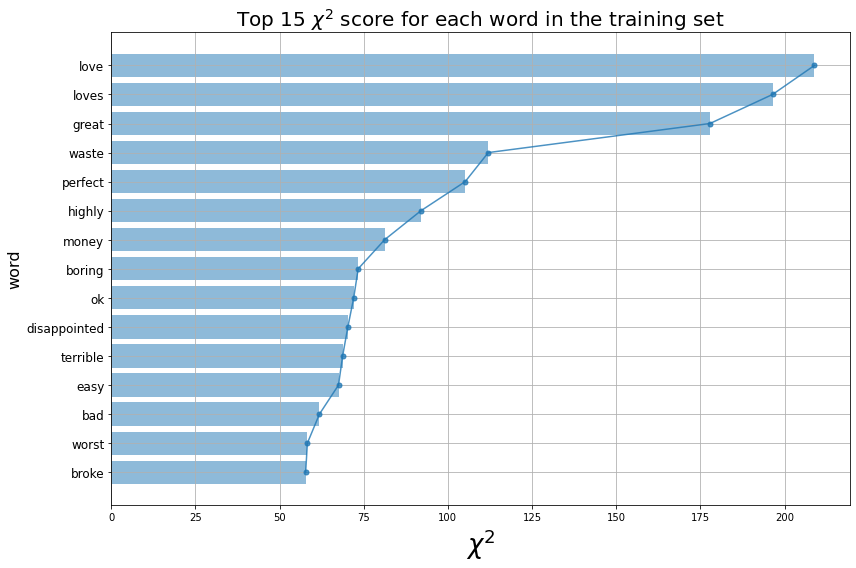

In [85]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Comprobamos arriba las n palabras mas utilizadas (en este ejemplo 15).

## Entrenamiento

In [86]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.75472
Accuracy for C=0.05: 0.77816
Accuracy for C=0.25: 0.79008
Accuracy for C=0.5: 0.7932
Accuracy for C=1: 0.79368
Accuracy for C=10: 0.78952
Accuracy for C=100: 0.78864
Accuracy for C=1000: 0.78872
Accuracy for C=10000: 0.78888


Comprobamos algunas metricas como la matriz de confusion, el accuracy y el classification_report.

In [87]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[4890 1305]
 [1334 4971]]

Classification report:
              precision    recall  f1-score   support

         neg       0.79      0.79      0.79      6195
         pos       0.79      0.79      0.79      6305

    accuracy                           0.79     12500
   macro avg       0.79      0.79      0.79     12500
weighted avg       0.79      0.79      0.79     12500

Accuracy score:0.78888


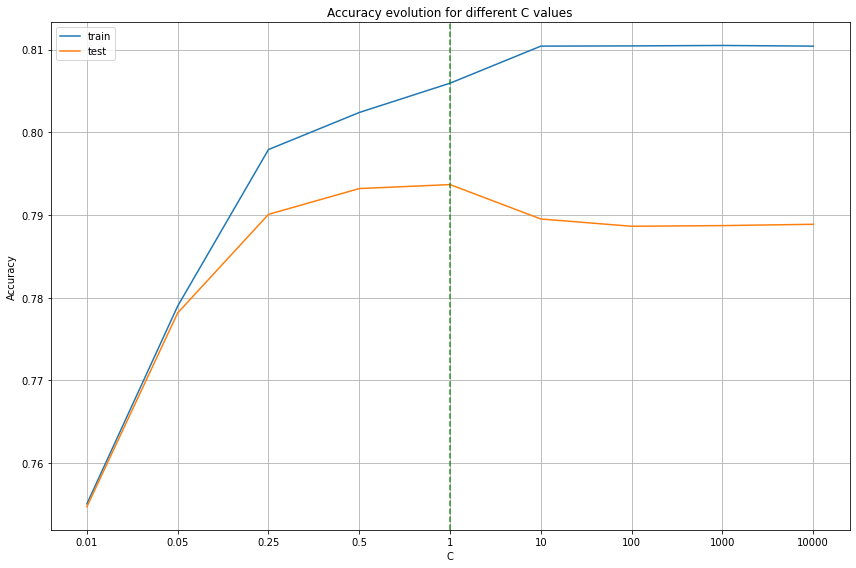

In [88]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

Pintamos la diferencia entre train / test.

# Predict

In [89]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [90]:
for i in random.sample(range(0, len(df)), 25):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 43435
Actual sentiment: pos
Prediction: ['pos']

Review no. 42967
Actual sentiment: neg
Prediction: ['neg']

Review no. 27839
Actual sentiment: pos
Prediction: ['pos']

Review no. 17032
Actual sentiment: neg
Prediction: ['neg']

Review no. 33557
Actual sentiment: neg
Prediction: ['pos']

Review no. 14190
Actual sentiment: pos
Prediction: ['pos']

Review no. 14733
Actual sentiment: pos
Prediction: ['pos']

Review no. 31816
Actual sentiment: neg
Prediction: ['neg']

Review no. 23780
Actual sentiment: pos
Prediction: ['pos']

Review no. 36917
Actual sentiment: pos
Prediction: ['pos']

Review no. 45331
Actual sentiment: pos
Prediction: ['pos']

Review no. 24027
Actual sentiment: pos
Prediction: ['neg']

Review no. 49229
Actual sentiment: pos
Prediction: ['pos']

Review no. 34655
Actual sentiment: pos
Prediction: ['pos']

Review no. 47272
Actual sentiment: pos
Prediction: ['pos']

Review no. 18697
Actual sentiment: neg
Prediction: ['neg']

Review no. 38139
Actual sentiment: neg


Variamos el parametro ngram_range para comprobar como se comporta con mas rango de palabras.

In [91]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=1500,
    strip_accents='ascii',
    #ngram_range=(1, 1), #variar el rango para el ngram
    #ngram_range=(2, 3),
    ngram_range=(3, 3)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=1500, min_df=5, ngram_range=(3, 3),
                strip_accents='ascii')

<>:14: DeprecationWarning: invalid escape sequence \c
<>:16: DeprecationWarning: invalid escape sequence \c
<>:14: DeprecationWarning: invalid escape sequence \c
<>:16: DeprecationWarning: invalid escape sequence \c
<>:14: DeprecationWarning: invalid escape sequence \c
<>:16: DeprecationWarning: invalid escape sequence \c
<ipython-input-92-575bec164b59>:14: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('$\chi^2$', fontsize=26)
<ipython-input-92-575bec164b59>:16: DeprecationWarning: invalid escape sequence \c
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


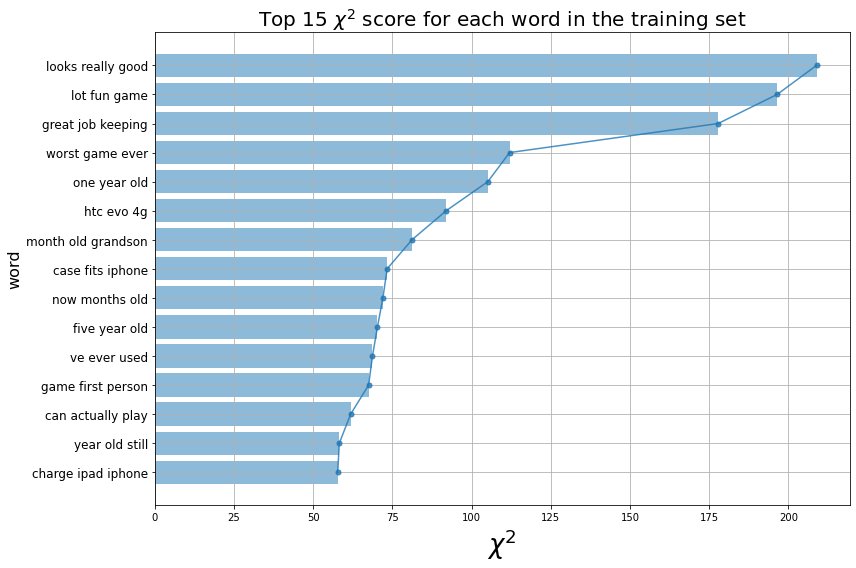

In [92]:
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Comprobamos con ngrams=3 como es de interesante la distribucion del top ngrams, aparece una marca como htc (tendriamos que analizar si para positivo o negativo), aparece game first person algo que parece que demandan en el sector de videojuegos y como top looks really good.

In [93]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.75472
Accuracy for C=0.05: 0.77816
Accuracy for C=0.25: 0.79008
Accuracy for C=0.5: 0.7932
Accuracy for C=1: 0.79368
Accuracy for C=10: 0.78952
Accuracy for C=100: 0.78864
Accuracy for C=1000: 0.78872
Accuracy for C=10000: 0.78888


In [94]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[4890 1305]
 [1334 4971]]

Classification report:
              precision    recall  f1-score   support

         neg       0.79      0.79      0.79      6195
         pos       0.79      0.79      0.79      6305

    accuracy                           0.79     12500
   macro avg       0.79      0.79      0.79     12500
weighted avg       0.79      0.79      0.79     12500

Accuracy score:0.78888


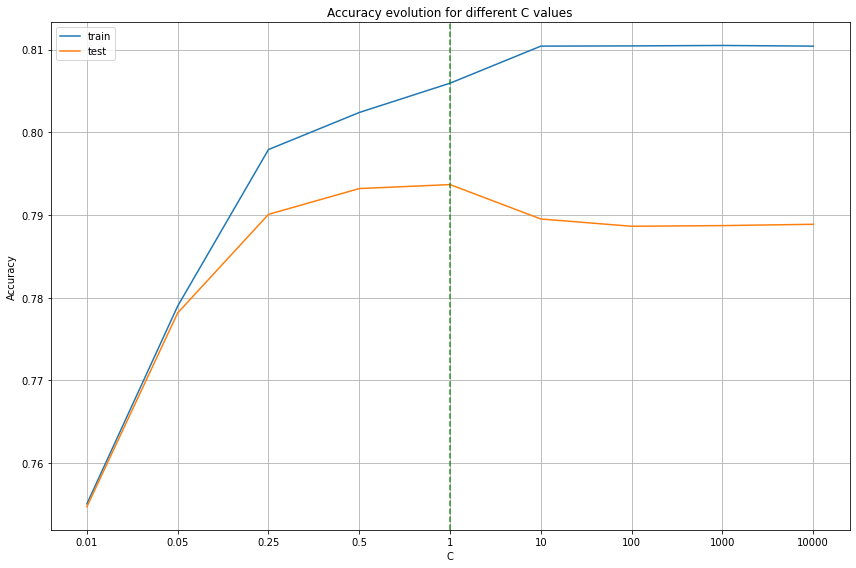

In [95]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [96]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['reviewText']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [97]:
for i in random.sample(range(0, len(df)), 25):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 44815
Actual sentiment: pos
Prediction: ['pos']

Review no. 23596
Actual sentiment: pos
Prediction: ['neg']

Review no. 3437
Actual sentiment: neg
Prediction: ['neg']

Review no. 25792
Actual sentiment: neg
Prediction: ['pos']

Review no. 23481
Actual sentiment: pos
Prediction: ['pos']

Review no. 36699
Actual sentiment: neg
Prediction: ['neg']

Review no. 44134
Actual sentiment: pos
Prediction: ['neg']

Review no. 2743
Actual sentiment: neg
Prediction: ['pos']

Review no. 26252
Actual sentiment: neg
Prediction: ['neg']

Review no. 24680
Actual sentiment: neg
Prediction: ['neg']

Review no. 499
Actual sentiment: neg
Prediction: ['neg']

Review no. 40629
Actual sentiment: neg
Prediction: ['neg']

Review no. 41151
Actual sentiment: neg
Prediction: ['neg']

Review no. 14857
Actual sentiment: neg
Prediction: ['neg']

Review no. 3755
Actual sentiment: neg
Prediction: ['neg']

Review no. 32592
Actual sentiment: pos
Prediction: ['neg']

Review no. 36388
Actual sentiment: neg
Predi

Observamos que con el poco preprocesado que hemos realizado apenas varia el accuracy con el ngrams debido principalmente al poco preprocesado que hemos realizado.

# Analisis con Vader

In [98]:
analyzer = SentimentIntensityAnalyzer()
df['rating'] = df['reviewText'].apply(analyzer.polarity_scores)
pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)

,reviewText,overall,sentiment_label,neg,neu,pos,compound
0,complaints product well made grandchildren lov...,3.0,neg,0.198,0.511,0.291,0.7328
1,probably fault doesn t hold phone maybe one cr...,3.0,neg,0.126,0.614,0.260,0.6808
2,item doesnt charge two devices timedoes charge...,1.0,neg,0.000,1.000,0.000,0.0000
3,s cool idea darn thing keeps closing baby s mo...,1.0,neg,0.000,0.766,0.234,0.6369
4,toy thrill son way baby einstein toy piano dis...,3.0,neg,0.121,0.604,0.275,0.4215
...,...,...,...,...,...,...,...
49995,realize leap pad come power source sad christm...,3.0,neg,0.220,0.780,0.000,-0.4767
49996,thoroughly enjoyed first gears war game sure s...,2.0,neg,0.112,0.616,0.273,0.9964
49997,amount hype flash game disappointment years th...,1.0,neg,0.090,0.707,0.203,0.7717
49998,bought pc underpowered now top notch rig cant ...,3.0,neg,0.133,0.708,0.159,0.0772


Voy a aplicar aqui otro preprocesado extra, para ver como varian los pesos del vader.

In [99]:
def text_cleaner(text,
                 deep_clean=False,
                 stem= True,
                 stop_words=True,
                 translite_rate=True):
    rules = [
        {r'>\s+': u'>'},  # remove spaces after a tag opens or closes
        {r'\s+': u' '},  # replace consecutive spaces
        {r'[ \t]*<[^<]*?/?>': u''},  # remove remaining tags
        {r'^\s+': u''}  # remove spaces at the beginning

    ]

    if deep_clean:
        text = text.replace(".", "")
        text = text.replace("[", " ")
        text = text.replace(",", " ")
        text = text.replace("]", " ")
        text = text.replace("(", " ")
        text = text.replace(")", " ")
        text = text.replace("\"", "")
        text = text.replace("-", " ")
        text = text.replace("=", " ")
        text = text.replace("?", " ")
        text = text.replace("!", " ")

        for rule in rules:
            for (k, v) in rule.items():
                regex = re.compile(k)
                text = regex.sub(v, text)
            text = text.rstrip()
            text = text.strip()
        text = text.replace('+', ' ').replace('.', ' ').replace(',', ' ').replace(':', ' ')
        text = re.sub("(^|\W)\d+($|\W)", " ", text)
        if translite_rate:
            text = transliterate(text)
        if stem:
            text = PorterStemmer().stem(text)
        text = WordNetLemmatizer().lemmatize(text)
        if stop_words:
            stop_words = set(stopwords.words('english'))
            word_tokens = word_tokenize(text)
            text = [w for w in word_tokens if not w in stop_words]
            text = ' '.join(str(e) for e in text)
    else:
        for rule in rules:
            for (k, v) in rule.items():
                regex = re.compile(k)
                text = regex.sub(v, text)
            text = text.rstrip()
            text = text.strip()
    return text.lower() 

<>:39: DeprecationWarning: invalid escape sequence \W
<>:39: DeprecationWarning: invalid escape sequence \W
<>:39: DeprecationWarning: invalid escape sequence \W
<ipython-input-99-3302e1ff4447>:39: DeprecationWarning: invalid escape sequence \W
  text = re.sub("(^|\W)\d+($|\W)", " ", text)


In [100]:
%%time
df['reviewText'] = df['reviewText'].apply(text_cleaner)

Wall time: 7.61 s


In [101]:
analyzer = SentimentIntensityAnalyzer()
df['rating'] = df['reviewText'].apply(analyzer.polarity_scores)
pd.concat([df.drop(['rating'], axis=1), df['rating'].apply(pd.Series)], axis=1)

,reviewText,overall,sentiment_label,neg,neu,pos,compound
0,complaints product well made grandchildren lov...,3.0,neg,0.198,0.511,0.291,0.7328
1,probably fault doesn t hold phone maybe one cr...,3.0,neg,0.126,0.614,0.260,0.6808
2,item doesnt charge two devices timedoes charge...,1.0,neg,0.000,1.000,0.000,0.0000
3,s cool idea darn thing keeps closing baby s mo...,1.0,neg,0.000,0.766,0.234,0.6369
4,toy thrill son way baby einstein toy piano dis...,3.0,neg,0.121,0.604,0.275,0.4215
...,...,...,...,...,...,...,...
49995,realize leap pad come power source sad christm...,3.0,neg,0.220,0.780,0.000,-0.4767
49996,thoroughly enjoyed first gears war game sure s...,2.0,neg,0.112,0.616,0.273,0.9964
49997,amount hype flash game disappointment years th...,1.0,neg,0.090,0.707,0.203,0.7717
49998,bought pc underpowered now top notch rig cant ...,3.0,neg,0.133,0.708,0.159,0.0772


Me ha parecido muy interesante el analisis con VADER y como realiza la composicion de neg-pos-neu, no he podido llegar a comprender como con un preprocesado pequeño o un preprocesado mas elaborado, no varia absolutamente nada el valor de cada composicion.

Bibliografia:

He realizado este ejercicio en base a las clases y notebooks vistos en el modulo y tambien he visitado la siguiente documentacion adicional tanto para utilizar codigo, ver explicacion de parametros o modelos.

https://www.ellaberintodefalken.com/2019/11/analisis-de-sentimiento-NLP.html

https://www.octoparse.es/blog/analisis-para-comentarios-de-hoteles

https://www.nltk.org/book/ch05.html

https://elitedatascience.com/imbalanced-classes

https://pybonacci.org/2015/11/24/como-hacer-analisis-de-sentimiento-en-espanol-2/

https://stackoverflow.com/questions/47947438/preprocessing-string-data-in-pandas-dataframe

https://medium.com/biaslyai/beginners-guide-to-text-preprocessing-in-python-2cbeafbf5f44

https://www.programcreek.com/python/example/91271/nltk.stem

In [ ]:
#Sentiment Analysis Report
#Finding sentiment analysis (+ve, -ve and neutral)
pos = 0
neg = 0
neu = 0
for tweet in searched_tweets:
    analysis = TextBlob(tweet.text)
    if analysis.sentiment[0]>0:
       pos = pos +1
    elif analysis.sentiment[0]<0:
       neg = neg + 1
    else:
       neu = neu + 1
print("Total Positive = ", pos)
print("Total Negative = ", neg)
print("Total Neutral = ", neu)

#Plotting sentiments
labels = 'Positive', 'Negative', 'Neutral'
sizes = [257, 223, 520]
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

Esta parte me ha quedado pendiente para realizar el analisis con una etiqueta de neu y no solamente neg-pos pero no he conseguido dar con ello.